# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

Ник на каггле - Reustlin\
Id на степике User ID: 527791760

В baseline используется "ручная" сборка нейросети, я же предлагаю использовать уже заранее предобученную с дообучение, выбор на ResNet, так же сделал вариант сравнения Resnet34 vs Resnet50

Resnet34, время обучения одной эпохи 3 минуты 16 секунд

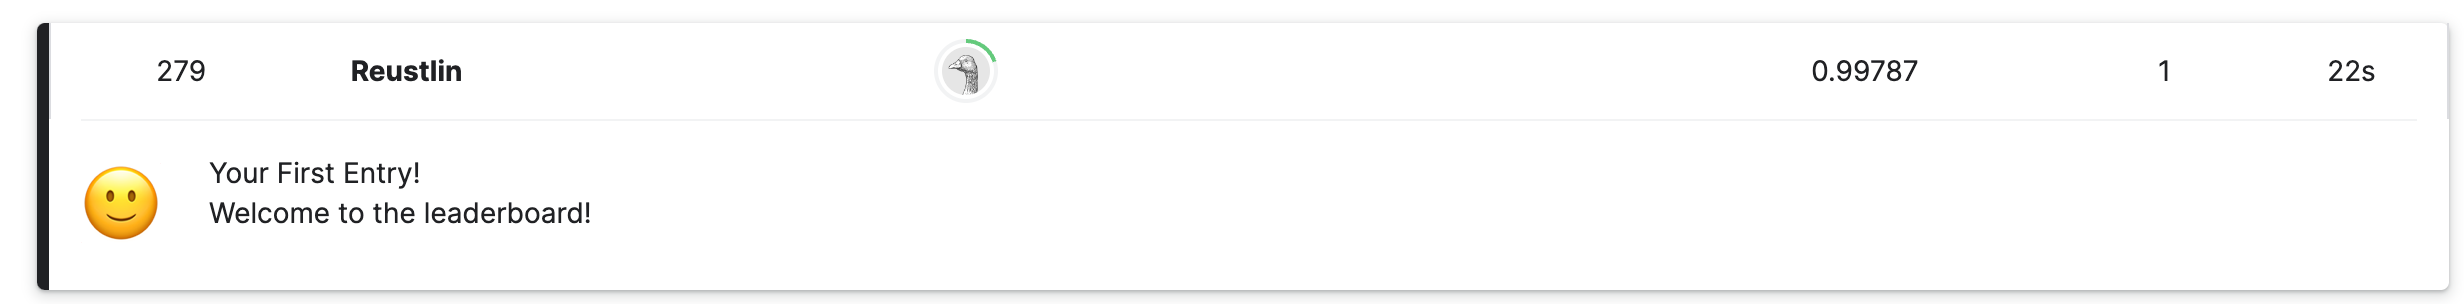

Resnet50, время обучения одной эпохи, 6 мину 43 секунды

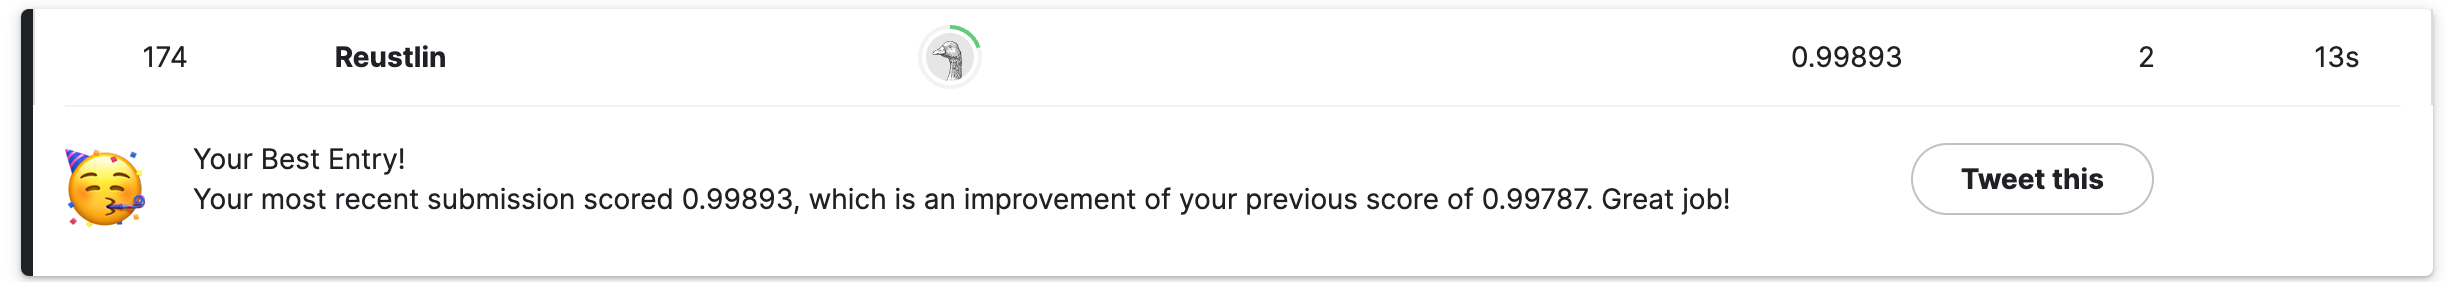

Вывод: 

resnet50 очень значительно дольше обучался, но показал совсем небольшой прирост в метрике, выбор архитектуры сети в данном случае уже больше зависит от потребности бизнеса, если это, например, определение данных с документов, то такая точность может быть и излишней, а если медицина, то тут каждая сотая важна

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import Counter

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import WeightedRandomSampler
from torchvision.datasets.folder import default_loader
from torchvision.models import resnet34, resnet50
import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_data_path = '/kaggle/input/journey-springfield/train/simpsons_dataset'
test_data_path = '/kaggle/input/journey-springfield/testset'
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_origin_image_folder = ImageFolder(root=train_data_path, transform=transform)
train_augmented_image_folder = ImageFolder(root=train_data_path, transform=augmented_transform)
train_image_folder = ConcatDataset([train_origin_image_folder, train_augmented_image_folder])

class_labels = [label for _, label in train_origin_image_folder.samples]
class_counts = Counter(class_labels)
total_samples = len(train_image_folder)
class_weights = [total_samples / (class_counts[i] * len(class_counts)) for i in class_labels]
sampler = WeightedRandomSampler(class_weights, num_samples=len(train_image_folder), replacement=True)

test_image_folder = ImageFolder(root=test_data_path, transform=transform)

In [5]:
batch_size=64
train_loader = DataLoader(train_image_folder, batch_size=batch_size, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_image_folder, shuffle=False)

In [6]:
ResNet = resnet34(weights=None)
ResNet.fc = nn.Linear(512, 42)(2048 for resnet50)
ResNet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def fit(epochs, model, loss_func, opt, train_dl, scheduler):
    train_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl, desc=f'{epoch+1} st train loop'):
            xb, yb, = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            loss.backward()
            opt.step()
        train_losses.append(loss_sum / len(train_dl))
        scheduler.step()

        print(f'Epoch {epoch+1}: Train Loss = {round(train_losses[-1], 7)},  lr = {scheduler.get_last_lr()[0]}')
        
    return train_losses


loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(ResNet.parameters(), lr=0.001)
scheduler = lr_scheduler.MultiStepLR(opt, milestones=[11, 14], gamma=0.5)

In [8]:
epochs = 16
info = fit(epochs, ResNet, loss_func, opt, train_loader, scheduler)

  0%|          | 0/16 [00:00<?, ?it/s]

1 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.4862814,  lr = 0.001


2 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.4093769,  lr = 0.001


3 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2239265,  lr = 0.001


4 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.1569282,  lr = 0.001


5 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.1178343,  lr = 0.001


6 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.1028981,  lr = 0.001


7 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.0831173,  lr = 0.001


8 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.0749319,  lr = 0.001


9 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.0565692,  lr = 0.001


10 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.0586841,  lr = 0.001


11 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.0533118,  lr = 0.0005


12 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.0151116,  lr = 0.0005


13 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.0067655,  lr = 0.0005


14 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.0131866,  lr = 0.00025


15 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.0064316,  lr = 0.00025


16 st train loop:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.003715,  lr = 0.00025


Обучение Resnet50

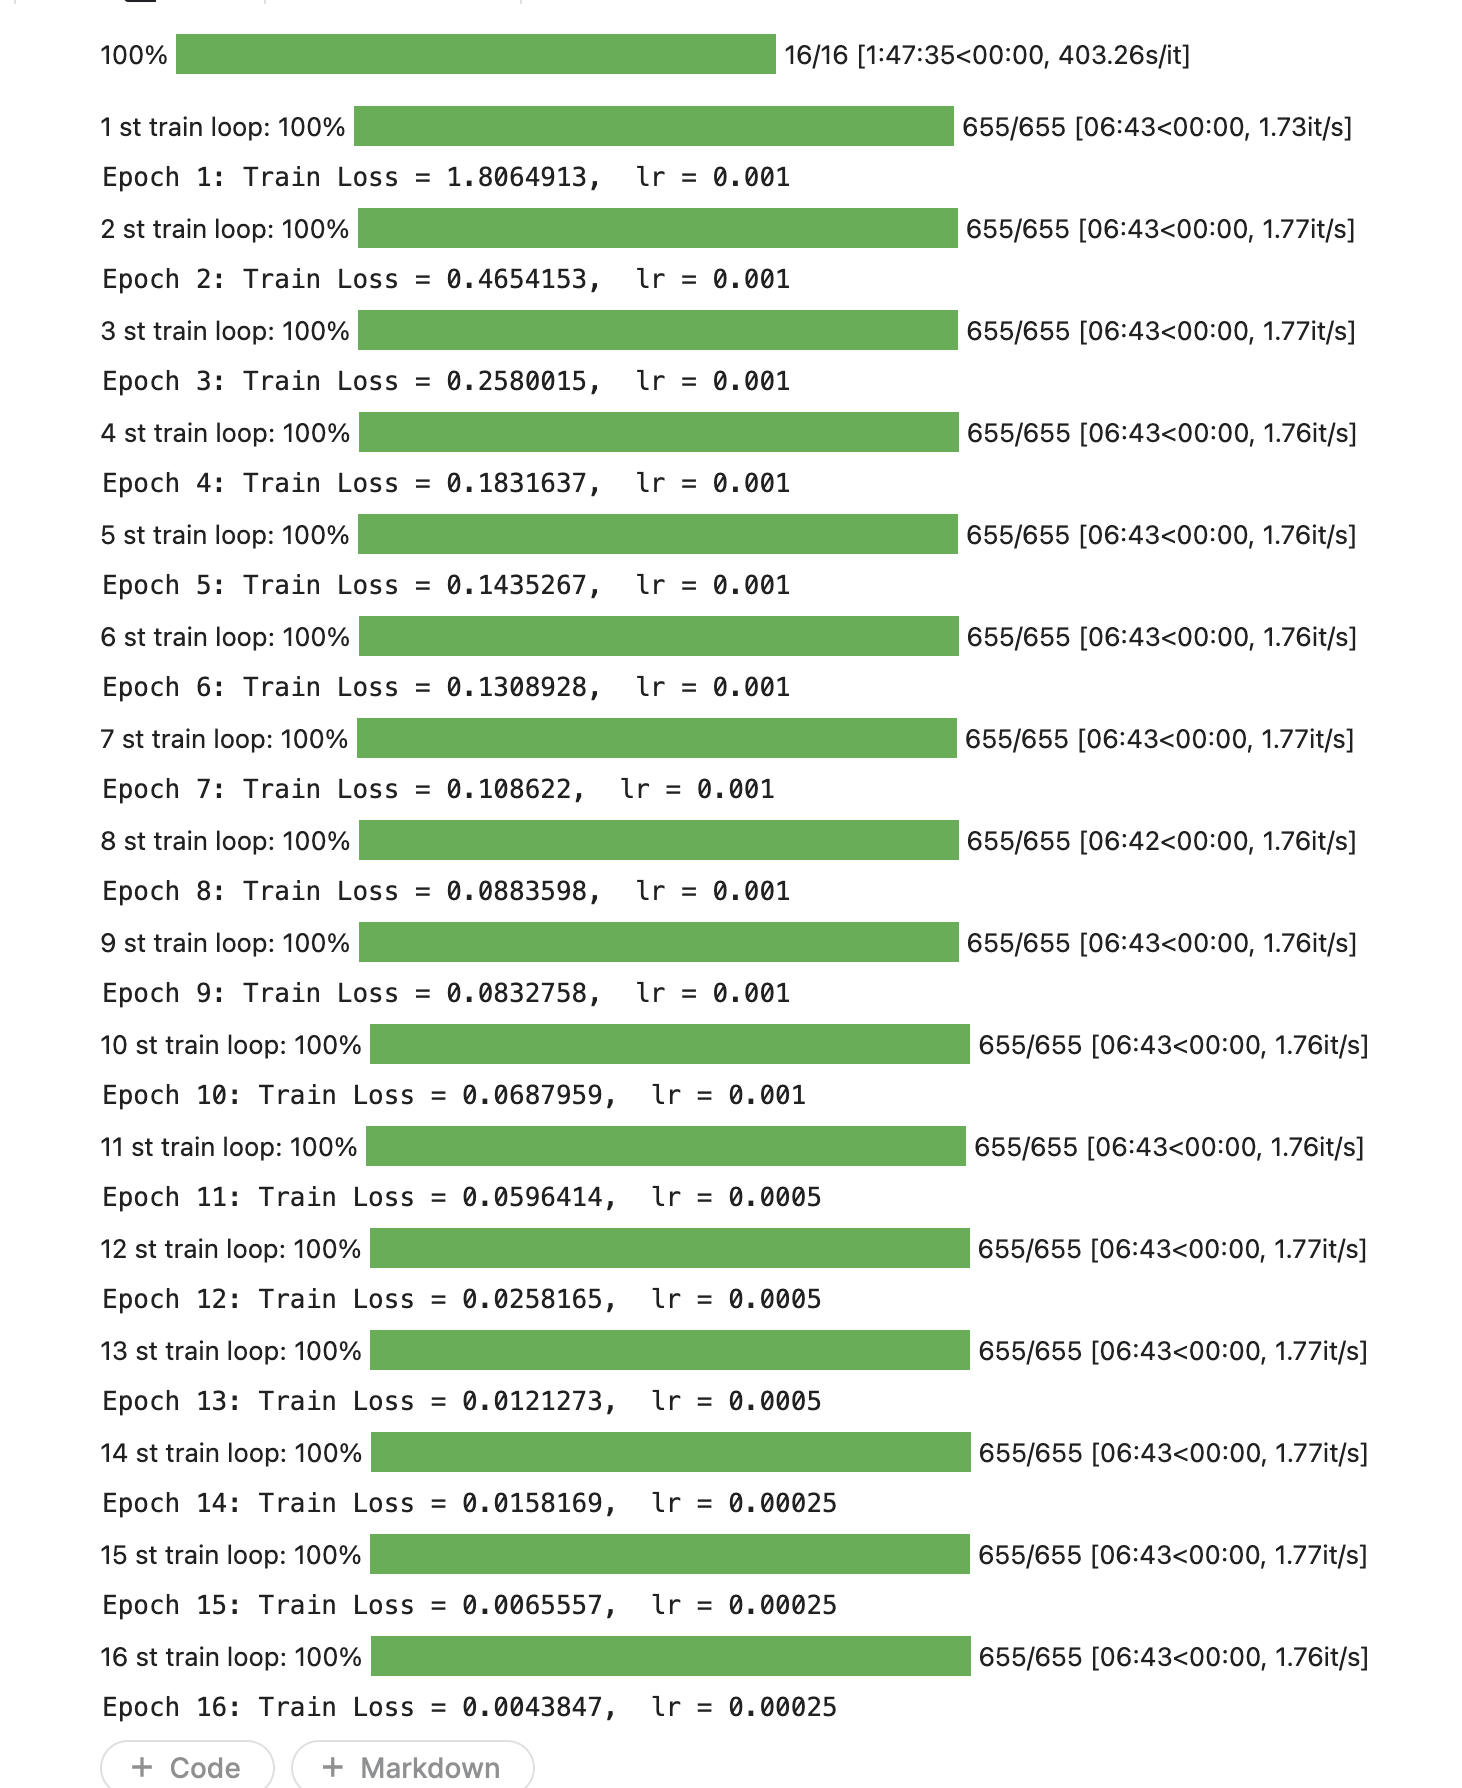

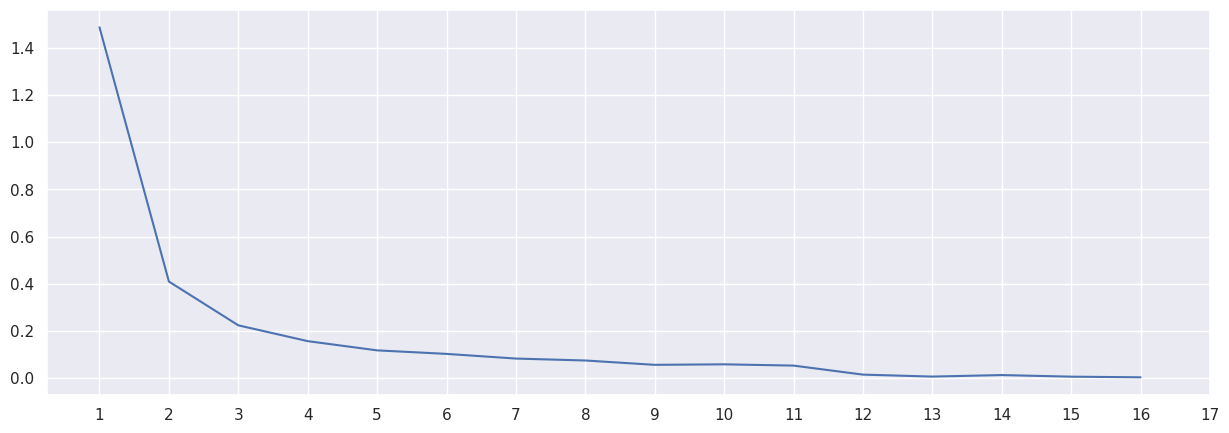

In [9]:
import seaborn as sns
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(1, 17), y=info)
plt.xticks(range(1, 18))
plt.show()

In [10]:
classes = train_origin_image_folder.classes
ResNet.eval()
y_pred = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        output = ResNet(x)
        logit = F.softmax(output, dim=1)
        _, pred_index = torch.max(logit, dim=1)
        y_pred.append(pred_index.item())


  0%|          | 0/991 [00:00<?, ?it/s]

In [12]:
from pathlib import Path

test_folder = '/kaggle/input/journey-springfield/testset/testset'
test_path = 'testset/testset'
test_files = sorted(list(Path(test_folder).rglob('*.jpg')))
preds = y_pred

submit = pd.DataFrame(columns=['Id'])

test_filenames = [path.name for path in test_files]
submit['Id'] = test_filenames
submit[f'Expected'] = [train_origin_image_folder.classes[pred] for pred in preds]
submit.sort_values(by=['Id'])
submit.to_csv('submission_ResNet_34_sampler_2023_11_09.csv', index=False)